# Imports

In [1]:
import os
import io
import numpy as np
import pandas as pd 
from pathlib import Path
import pickle

import torch
from torch import nn
import torch.nn.functional as F

from tqdm.auto import tqdm

import torchinfo
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision
from torchvision import datasets, models
from torchvision.transforms import ToTensor, Compose
from torchvision.transforms.functional import to_pil_image, pil_to_tensor

from sklearn.preprocessing import StandardScaler


import PIL

import matplotlib.pyplot as plt
from matplotlib import colormaps

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
art_dataset_path = Path("/kaggle/input/real-ai-art/Real_AI_Dataset/Real_AI_Dataset")

In [4]:
train_art_dir = art_dataset_path / "train"
valid_art_dir = art_dataset_path / "test" # Change later when validation set is available
test_art_dir = art_dataset_path / "test"

train_art_csv_dir = "/kaggle/input/real-ai-art/train_art_col_feat.csv"
valid_art_csv_dir = "/kaggle/input/real-ai-art/test_art_col_feat.csv" # Change later when validation set is available
test_art_csv_dir = "/kaggle/input/real-ai-art/test_art_col_feat.csv"

In [5]:
art_class_labels = [
    'AI_art_nouveau',
    'AI_baroque',
    'AI_expressionism',
    'AI_impressionism',
    'AI_post_impressionism',
    'AI_realism',
    'AI_renaissance',
    'AI_romanticism',
    'AI_surrealism',
    'AI_ukiyo-e',
    'art_nouveau',
    'baroque',
    'expressionism',
    'impressionism',
    'post_impressionism',
    'realism',
    'renaissance',
    'romanticism',
    'surrealism',
    'ukiyo_e']

# Feature Creation

In [6]:
def get_img_colour_features(image):
    rgb_img_features = np.array(image.resize((1,1))).squeeze()
    hsv_img_features = np.array(image.convert('HSV').resize((1,1))).squeeze()
    cmyk_img_features = np.array(image.convert('CMYK').resize((1,1))).squeeze()[:-1]
    
    return np.concatenate((rgb_img_features, hsv_img_features, cmyk_img_features)) # R G B H S V C M Y

In [7]:
#test_img = PIL.Image.open("/kaggle/input/artbench-10-256px/artbench-10-imagefolder-split/artbench-10-imagefolder-split/test/art_nouveau/achille-beltrame_fly-of-gabriele-dannunzio-over-trieste-1915.jpg")
#test_img = PIL.Image.open("/kaggle/input/artbench-10-256px/artbench-10-imagefolder-split/artbench-10-imagefolder-split/test/romanticism/albert-bierstadt_sentinel-falls-and-cathedral-peaks-in-the-yosemite-valley-1864.jpg")
#test_img = PIL.Image.open("/kaggle/input/artbench-10-256px/artbench-10-imagefolder-split/artbench-10-imagefolder-split/test/realism/abbott-handerson-thayer_azores.jpg")
test_img = PIL.Image.open("/kaggle/input/artbench-10-256px/artbench-10-imagefolder-split/artbench-10-imagefolder-split/test/ukiyo_e/chokosai-eisho_99.jpg")

In [8]:
test_img.filename

'/kaggle/input/artbench-10-256px/artbench-10-imagefolder-split/artbench-10-imagefolder-split/test/ukiyo_e/chokosai-eisho_99.jpg'

In [9]:
img_col_features = get_img_colour_features(test_img)
img_col_features

array([171, 160, 134,  30,  55, 171,  84,  95, 121], dtype=uint8)

In [10]:
def generate_col_features(dir_img_dataset):
    count = 0
    img_features = []

    for sub_dir, dirs, img_files in os.walk(dir_img_dataset):
        for img_filename in img_files:
            if img_filename.endswith(".jpg"):
                img_path = str(os.path.join(sub_dir, img_filename))
                img = PIL.Image.open(img_path)
                img_col_features = get_img_colour_features(img)

                img_features.append(
                    np.append(np.array(str(os.path.join(sub_dir, img_filename))),img_col_features)
                )
                count+=1

        print(sub_dir, count)

    return pd.DataFrame(
        data=img_features,
        columns=["Path", "Red","Green","Blue","Hue","Sat","Val","Cyan","Mag","Yel"] 
    )

In [11]:
# # Colour feature generation
# train_col_features = generate_col_features(train_art_dir)
# test_col_features = generate_col_features(test_art_dir)

# train_col_features["style"] = train_col_features.apply(lambda df_row: df_row["Path"].split("/")[-2], axis=1)
# test_col_features["style"] = test_col_features.apply(lambda df_row: df_row["Path"].split("/")[-2], axis=1)
# train_col_features["label"] = train_col_features.apply(lambda df_row: art_class_labels.index(df_row["style"]), axis=1)
# test_col_features["label"] = test_col_features.apply(lambda df_row: art_class_labels.index(df_row["style"]), axis=1)

# # Saving to CSV
# train_col_features.to_csv("train_art_col_feat.csv")
# test_col_features.to_csv("test_art_col_feat.csv")

# raise SystemExit("Stop right there!")

In [12]:
train_col_features = pd.read_csv("/kaggle/input/real-ai-art/train_art_col_feat.csv")
test_col_features = pd.read_csv("/kaggle/input/real-ai-art/test_art_col_feat.csv")
train_col_features.drop("Unnamed: 0", inplace=True, axis=1, errors='ignore')
test_col_features.drop("Unnamed: 0", inplace=True, axis=1, errors='ignore')

In [13]:
train_col_features.head()

,Path,Red,Green,Blue,Hue,Sat,Val,Cyan,Mag,Yel,style,label
0,/kaggle/input/real-ai-art/Real_AI_Dataset/trai...,144,133,106,59,101,153,111,122,149,AI_romanticism,7
1,/kaggle/input/real-ai-art/Real_AI_Dataset/trai...,115,101,79,35,95,117,140,154,176,AI_romanticism,7
2,/kaggle/input/real-ai-art/Real_AI_Dataset/trai...,125,92,56,31,145,126,130,163,199,AI_romanticism,7
3,/kaggle/input/real-ai-art/Real_AI_Dataset/trai...,101,107,91,82,59,112,154,148,164,AI_romanticism,7
4,/kaggle/input/real-ai-art/Real_AI_Dataset/trai...,123,102,75,43,107,125,132,153,180,AI_romanticism,7


In [14]:
scaler = StandardScaler()

train_col_features[train_col_features.columns[1:10]] = scaler.fit_transform(train_col_features[train_col_features.columns[1:10]])
test_col_features[test_col_features.columns[1:10]] = scaler.fit_transform(test_col_features[test_col_features.columns[1:10]])

In [15]:
test_col_features.head()

,Path,Red,Green,Blue,Hue,Sat,Val,Cyan,Mag,Yel,style,label
0,/kaggle/input/real-ai-art/Real_AI_Dataset/test...,-0.400980,-0.284053,-0.229756,-0.190896,-0.848659,-0.763740,0.400962,0.284037,0.229744,AI_romanticism,7
1,/kaggle/input/real-ai-art/Real_AI_Dataset/test...,-0.462682,-0.470689,-0.659680,-0.779932,-0.196895,-0.851866,0.462664,0.470672,0.659672,AI_romanticism,7
2,/kaggle/input/real-ai-art/Real_AI_Dataset/test...,-0.370130,-0.719537,-0.401725,0.486495,-0.718306,-0.822490,0.370111,0.719519,0.401715,AI_romanticism,7
3,/kaggle/input/real-ai-art/Real_AI_Dataset/test...,-0.339279,-0.159630,-0.229756,-0.397059,-0.544502,-0.616863,0.339261,0.159613,0.229744,AI_romanticism,7
4,/kaggle/input/real-ai-art/Real_AI_Dataset/test...,-0.215876,-0.564007,-0.717003,-1.133354,-0.023092,-0.704989,0.215857,0.563990,0.716995,AI_romanticism,7


In [16]:
# Code to check any dulplicate files under same name
# count = 0
# for sub_dir, dirs, img_files in os.walk(test_art_dir):
#     for img_filename in img_files:
#         if img_filename.endswith(".jpg"):
#             if len(test_col_features[test_col_features['Path'].str.endswith("/"+img_filename.split("/")[-1])].iloc[:,1:-2].values) != 1:
#                 print(sub_dir, img_filename)
#             count+=1

#     print(sub_dir, count)

# Dataset Creation

In [17]:
# Make a CSV with addictional features 
# Build a class like below to integrate the features with the image and the label
# https://medium.com/bivek-adhikari/creating-custom-datasets-and-dataloaders-with-pytorch-7e9d2f06b660
# https://pytorch.org/vision/stable/_modules/torchvision/datasets/folder.html#ImageFolder
# Inherit the DatasetFolder class and overide the __get__() function
from sklearn.preprocessing import StandardScaler
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader, IMG_EXTENSIONS

class ArtStyleDataset(DatasetFolder):

    def __init__(self, dir_root, csv_file_path, transform=None, 
                 target_transform=None, is_valid_file=None, feature_scaler=None):
        super().__init__(
            dir_root,
            default_loader,
            IMG_EXTENSIONS if is_valid_file is None else None,
            transform=transform
        )
        
        self.dir_root = dir_root
        self.transform = transform
        self.feature_scaler = feature_scaler
        self.img_feat_data = self.get_preprocesseed_features(csv_file_path) # Path Red Green Blue Hue Sat Val Cyan Mag Yel style label

    def __len__(self) -> int:
        return len(self.samples)
    
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        img_feature = self.img_feat_data[index]
        
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, img_feature, target

    
    def get_preprocesseed_features(self, csv_file_path):
        """
        Preprocesses the image features
        """
        print("Preprecessing...")
        
        col_features_tensor_list = []
        col_features = pd.read_csv(csv_file_path)
        col_features.drop("Unnamed: 0", inplace=True, axis=1, errors='ignore')
        
        # Scaling
        if self.feature_scaler is None:
            self.feature_scaler = StandardScaler().fit(col_features[col_features.columns[1:10]])
        col_features[col_features.columns[1:10]] = self.feature_scaler.transform(col_features[col_features.columns[1:10]])
        
        for path, _ in tqdm(self.samples):
            col_features_tensor_list.append(
                torch.Tensor(
                    col_features[col_features['Path'].str.endswith("/"+path.split("/")[-1])].iloc[:,1:-2].values
                )
            )
        
        print("Feature count: ", len(col_features_tensor_list))
        
        return col_features_tensor_list


In [18]:
# TODO: Must be done with the custom dataset to be created
imagenet_weights = models.ConvNeXt_Base_Weights.DEFAULT
preprocess_transforms = imagenet_weights.transforms()
preprocess_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [19]:
exp_data = ArtStyleDataset( # EXPERIMENT!!!!!!!!!!!!!!!!!
    valid_art_dir,
    "/kaggle/input/real-ai-art/test_art_col_feat.csv",
    transform=preprocess_transforms
)

Preprecessing...


  0%|          | 0/20000 [00:00<?, ?it/s]

Feature count:  20000


In [20]:
# with open('./test_col_feature_scaler.pkl','wb') as sc_f:
#     pickle.dump(exp_data.feature_scaler, sc_f)
# # with open('./test_col_feature_scaler.pkl','rb') as sc_f:
# #     sc = pickle.load(sc_f)

In [21]:
print("Means: ", exp_data.feature_scaler.mean_)
print("Var: ", exp_data.feature_scaler.var_)

Means:  [122.99745 116.1318   98.01615  69.48165 107.0629  140.9994  132.0032
 138.8687  156.9843 ]
Var:  [1050.6799435  1033.50492876 1217.30368918 1152.85946328 2118.66854359
 1158.87289964 1050.66918976 1033.51216031 1217.28615351]


Label: 0
Feature: tensor([[-0.4627,  0.2136, -0.4590,  0.0153,  0.8894, -0.0881,  0.4627, -0.2137,
          0.4590]])


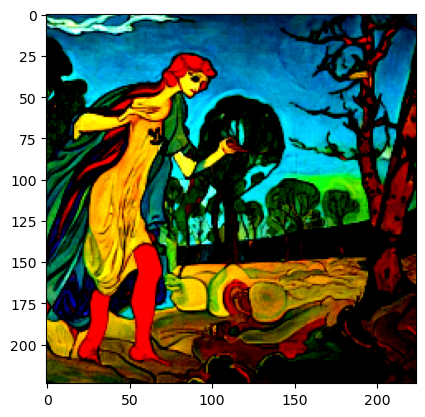

In [22]:
def show_image(image, img_feature, label):
    print(f"Label: {label}") 
    print(f"Feature: {img_feature}") 
    plt.imshow(image.permute(1,2,0))
    plt.show()

show_image(*exp_data[0])

In [23]:
exp_data_dl = DataLoader(
    exp_data,
    batch_size=1,
    shuffle=True,
    num_workers=os.cpu_count()
)

In [24]:
NUM_WORKERS = os.cpu_count()

def get_art_image_dl(
    train_dir: str,
    train_csv_dir: str,
    valid_dir: str,
    valid_csv_dir: str,
    test_dir: str,
    test_csv_dir: str,
    pin_memory: bool,
    transform: Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
    """
    Dataset Generation
    """

    print("Train split creation...")
    # Creation of DataLoaders from Datasets
    train_data = ArtStyleDataset(
        train_dir,
        train_csv_dir,
        transform=transform
    )
    train_data_dl = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    
    print("Validation split creation...")
    valid_data = ArtStyleDataset(
        valid_dir,
        valid_csv_dir,
        transform=transform
    )
    valid_data_dl = DataLoader(
        valid_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    
    print("Test split creation...")
    test_data = ArtStyleDataset(
        test_dir,
        test_csv_dir,
        transform=transform,
        feature_scaler=train_data.feature_scaler
    )
    test_data_dl = DataLoader(
        test_data,
        batch_size=1,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    
    print("Colour feature Means     : ", train_data.feature_scaler.mean_)
    print("Colour feature Variances : ", train_data.feature_scaler.var_)
    
    print("Svaing standard scaler...")
    with open('./col_feature_scaler.pkl','wb') as sc_f:
        pickle.dump(train_data.feature_scaler, sc_f)

    return train_data_dl, valid_data_dl, test_data_dl, train_data.classes, train_data.feature_scaler

In [25]:
BATCH_SIZE=32

In [26]:
train_art_dl, valid_art_dl, test_art_dl, art_style_classes, col_feature_scaler = get_art_image_dl(
    train_dir=train_art_dir, 
    valid_dir=valid_art_dir, 
    test_dir=test_art_dir,
    train_csv_dir=train_art_csv_dir, 
    valid_csv_dir=valid_art_csv_dir, 
    test_csv_dir=test_art_csv_dir,
    pin_memory=True,
    transform=preprocess_transforms,
    batch_size=BATCH_SIZE
)

Train split creation...
Preprecessing...


  0%|          | 0/102923 [00:00<?, ?it/s]

Feature count:  102923
Validation split creation...
Preprecessing...


  0%|          | 0/20000 [00:00<?, ?it/s]

Feature count:  20000
Test split creation...
Preprecessing...


  0%|          | 0/20000 [00:00<?, ?it/s]

Feature count:  20000
Colour feature Means     :  [122.47748317 115.93326079  97.72829202  69.97529221 108.09235059
 141.08971756 132.52303178 139.0673999  157.27234923]
Colour feature Variances :  [1025.44881676 1002.38744079 1168.45164527 1147.68228839 2124.79274028
 1140.55633384 1025.44113709 1002.3892565  1168.44801238]
Svaing standard scaler...


In [27]:
print(f"Train Size      : {len(train_art_dl)} | Batch Size: {BATCH_SIZE}")
print(f"Validation Size : {len(valid_art_dl)} | Batch Size: {BATCH_SIZE}")
print(f"Test Size       : {len(test_art_dl)}  | Batch Size: {1}")

Train Size      : 3217 | Batch Size: 32
Validation Size : 625 | Batch Size: 32
Test Size       : 20000  | Batch Size: 1


# Data Exploration

In [28]:
train_art_img_batch, train_col_feat_batch, train_art_labels_batch = next(iter(train_art_dl))
train_art_img_batch.shape, train_col_feat_batch.shape, train_art_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 1, 9]), torch.Size([32]))

In [29]:
img_filename, art_style_label = train_art_img_batch[0], train_art_labels_batch[0]

In [30]:
img_ch, img_h, img_w = img_filename.shape
img_ch, img_h, img_w

(3, 224, 224)

In [31]:
art_style_label

tensor(2)

In [32]:
art_style_classes

['AI_art_nouveau',
 'AI_baroque',
 'AI_expressionism',
 'AI_impressionism',
 'AI_post_impressionism',
 'AI_realism',
 'AI_renaissance',
 'AI_romanticism',
 'AI_surrealism',
 'AI_ukiyo-e',
 'art_nouveau',
 'baroque',
 'expressionism',
 'impressionism',
 'post_impressionism',
 'realism',
 'renaissance',
 'romanticism',
 'surrealism',
 'ukiyo_e']

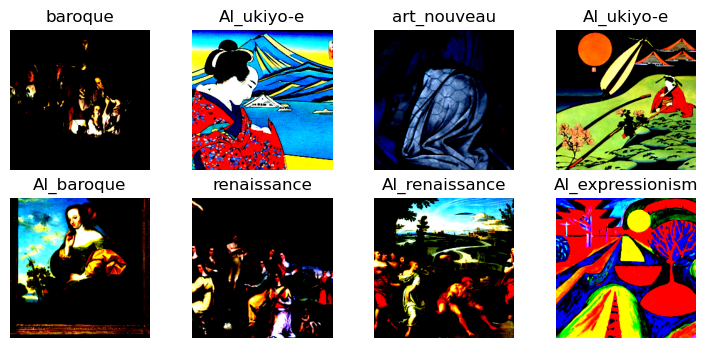

In [33]:
fg = plt.figure(figsize=(9, 4))
rows, cols = 2, 4
for i in range(1, rows * cols + 1):
    rand_art_idx = torch.randint(0, len(train_art_img_batch), size=[1]).item()
    art_img, art_style_label = train_art_img_batch[rand_art_idx], train_art_labels_batch[rand_art_idx]
    fg.add_subplot(rows, cols, i)
    plt.imshow(art_img.squeeze().permute(1, 2, 0), cmap="gray")
    plt.title(art_style_classes[art_style_label])
    plt.axis(False);

# Model Development

Potential improvements
- Colour percentages
- Egdes

In [34]:
from torchvision.models import convnext_base
from torchvision.models import ConvNeXt_Base_Weights
class ArtVisionModel(nn.Module):
    
    def __init__(self, n_classes, n_art_img_features=9):
        super(ArtVisionModel, self).__init__()
        
        # Pretrained ConvNeXt
        self.convnext = convnext_base(weights=ConvNeXt_Base_Weights.DEFAULT)
        
        # Features
        self.features = self.convnext.features
        
        # CNBlock pooling layer
        self.cnb_pooling = nn.Sequential(
            self.convnext.avgpool,
            self.convnext.classifier[0],
            nn.Flatten()
        )
                
        # Colour features
        self.col_features = nn.Sequential(
            nn.Linear(
                in_features=n_art_img_features,
                out_features=64,
                bias=True
            ),
            nn.Flatten()
        )

        # Classifier portion
        self.classifier = nn.Sequential(
#             self.convnext.classifier[0],
#             nn.Flatten(),
            nn.Dropout(p=0.4), 
            nn.Linear(
                in_features=1024+64,
                out_features=256,
                bias=True
            ),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(
                in_features=256,
                out_features=n_classes,
                bias=True
            )
        )

    
    def forward(self, img, img_feat):
        # Features
        img = self.features(img)
        
        # Pooling
        img = self.cnb_pooling(img)
        
        # Colour features
        img_feat = self.col_features(img_feat)
        
        x =  torch.cat((img, img_feat), dim=1)
                
        # Classifier
        x = self.classifier(x)
        
        return x
    

In [35]:
# art_vision_model = torch.load("/kaggle/input/art-model-pytorch/art_brain_model.pt", map_location=device)
# model_scripted = torch.jit.script(art_vision_model)# Export to TorchScript

# model_scripted.save('art_brain_model_scripted.pt') # Save
#torch.save(art_vision_model.state_dict(), "./art_vision_model_state.pt")

In [36]:
art_vision_model = ArtVisionModel(n_classes=len(art_style_classes)).to(device)

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:06<00:00, 57.3MB/s]


In [37]:
art_vision_model.features[-1][-1]

CNBlock(
  (block): Sequential(
    (0): Conv2d(1024, 1024, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=1024)
    (1): Permute()
    (2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
    (3): Linear(in_features=1024, out_features=4096, bias=True)
    (4): GELU(approximate='none')
    (5): Linear(in_features=4096, out_features=1024, bias=True)
    (6): Permute()
  )
  (stochastic_depth): StochasticDepth(p=0.5, mode=row)
)

In [38]:
# Freezing top params of the model
for train_param in art_vision_model.features[:-1].parameters():
    train_param.requires_grad = False

In [39]:
torchinfo.summary(
    model=art_vision_model, 
    input_size=[(32, 3, img_h, img_w), (32, 9)],
    # col_names=["input_size"],
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
) 

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ArtVisionModel (ArtVisionModel)                         [32, 3, 224, 224]    [32, 20]             1,025,000            Partial
├─Sequential (features)                                 [32, 3, 224, 224]    [32, 1024, 7, 7]     --                   Partial
│    └─Conv2dNormActivation (0)                         [32, 3, 224, 224]    [32, 128, 56, 56]    --                   False
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 128, 56, 56]    (6,272)              False
│    │    └─LayerNorm2d (1)                             [32, 128, 56, 56]    [32, 128, 56, 56]    (256)                False
│    └─Sequential (1)                                   [32, 128, 56, 56]    [32, 128, 56, 56]    --                   False
│    │    └─CNBlock (0)                                 [32, 128, 56, 56]    [32, 128, 56, 56]    (138,496)          

In [40]:
#art_vision_model = nn.DataParallel(art_vision_model)

In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(art_vision_model.parameters(), lr=0.001)
lr_scheduler = ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=2, 
    threshold=0.0001, cooldown=0, min_lr=1e-06, verbose=True
)

In [42]:
"""
Contains functions for training and testing a PyTorch model.
"""

from typing import Dict, List, Tuple

def train_step_procedure(
    epoch: int,
    model: torch.nn.Module, 
    train_dl: torch.utils.data.DataLoader, 
    loss_fn: torch.nn.Module, 
    optimizer: torch.optim.Optimizer,
    device: torch.device) -> Tuple[float, float]:
    """
    
    """
    model.train()

    train_step_loss, train_step_acc = 0, 0
    
    training_pbar = tqdm(enumerate(train_dl), unit="batch", total=len(train_dl))
    training_pbar.set_description("Epoch %02d" % (epoch+1))

    for batch, (train_image, train_feat, img_label) in training_pbar:
        
        train_image, train_feat, img_label = train_image.to(device), train_feat.to(device), img_label.to(device)

        # Forward propagation
        y_pred = model(train_image, train_feat)

        # Loss calcluation
        loss = loss_fn(y_pred, img_label)
        train_step_loss += loss.item() 
        avg_train_step_loss = train_step_loss/(batch+1)
        training_pbar.set_postfix({'Loss': "%.4f" % avg_train_step_loss})

        # Resetting optimizer
        optimizer.zero_grad()

        # Backward propagation
        loss.backward()

        # Weight optimisation
        optimizer.step()

        # Per batch Accuracy calculation
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_step_acc += (y_pred_class == img_label).sum().item()/len(y_pred)

    # Epoch train loss and accuracy
    train_step_loss /= len(train_dl)
    train_step_acc /= len(train_dl)
    return train_step_loss, train_step_acc

def validation_step_procedure(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """
    
    """
    # Evaluation mode activation
    model.eval() 

    # Setup test loss and test accuracy values
    valid_step_loss, valid_step_acc = 0, 0

    # Torch inference context manager for efficient performance
    with torch.inference_mode():
        for batch, (valid_image, valid_feat, valid_label) in enumerate(dataloader):
            valid_image, valid_feat, valid_label = valid_image.to(device), valid_feat.to(device), valid_label.to(device)

            valid_pred = model(valid_image, valid_feat)

            # Batch loss
            loss = loss_fn(valid_pred, valid_label)
            valid_step_loss += loss.item()

            # Batch accuracy
            valid_pred_labels = valid_pred.argmax(dim=1)
            valid_step_acc += ((valid_pred_labels == valid_label).sum().item()/len(valid_pred_labels))

    valid_step_loss = valid_step_loss / len(dataloader)
    valid_step_acc = valid_step_acc / len(dataloader)
    return valid_step_loss, valid_step_acc

def train(
    model: torch.nn.Module, 
    train_dl: torch.utils.data.DataLoader, 
    validation_dl: torch.utils.data.DataLoader, 
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    lr_scheduler: torch.optim.lr_scheduler,
    device: torch.device
) -> Dict[str, List]:
    """
    
    """
    results = {"train_loss": [],
               "train_acc": [],
               "valid_loss": [],
               "valid_acc": [],
               "lr": []
    }
    
    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step_procedure(
            epoch=epoch,
            model=model,
            train_dl=train_dl,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )
        
        valid_loss, valid_acc = validation_step_procedure(
            model=model,
            dataloader=validation_dl,
            loss_fn=loss_fn,
            device=device
        )
        
                
        # Learning rate adjustments
        lr_scheduler.step(valid_loss)

        print(
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"valid_loss: {valid_loss:.4f} | "
          f"valid_acc: {valid_acc:.4f} | "
          f"lr: {optimizer.param_groups[0]['lr']}"
        )

        # Updating results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["valid_loss"].append(valid_loss)
        results["valid_acc"].append(valid_acc)
        results["lr"].append(optimizer.param_groups[0]['lr'])

    return results

In [43]:
#torch.randn(3, 5, requires_grad=True), torch.empty(3, dtype=torch.long).random_(5)

In [44]:
epochs = 15

In [45]:
train_restults = train(
    model=art_vision_model, 
    train_dl=train_art_dl, 
    validation_dl=valid_art_dl, 
    optimizer=optimizer,
    loss_fn=loss_fn,
    lr_scheduler=lr_scheduler,
    epochs=epochs,
    device=device
)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3217 [00:00<?, ?batch/s]

train_loss: 0.6879 | train_acc: 0.7503 | valid_loss: 0.5410 | valid_acc: 0.7987 | lr: 0.001


  0%|          | 0/3217 [00:00<?, ?batch/s]

train_loss: 0.5701 | train_acc: 0.7883 | valid_loss: 0.5293 | valid_acc: 0.8072 | lr: 0.001


  0%|          | 0/3217 [00:00<?, ?batch/s]

train_loss: 0.5368 | train_acc: 0.8015 | valid_loss: 0.5033 | valid_acc: 0.8145 | lr: 0.001


  0%|          | 0/3217 [00:00<?, ?batch/s]

train_loss: 0.5123 | train_acc: 0.8107 | valid_loss: 0.5072 | valid_acc: 0.8131 | lr: 0.001


  0%|          | 0/3217 [00:00<?, ?batch/s]

train_loss: 0.4828 | train_acc: 0.8221 | valid_loss: 0.4861 | valid_acc: 0.8218 | lr: 0.001


  0%|          | 0/3217 [00:00<?, ?batch/s]

train_loss: 0.4615 | train_acc: 0.8287 | valid_loss: 0.4948 | valid_acc: 0.8253 | lr: 0.001


  0%|          | 0/3217 [00:00<?, ?batch/s]

train_loss: 0.4413 | train_acc: 0.8377 | valid_loss: 0.4884 | valid_acc: 0.8234 | lr: 0.001


  0%|          | 0/3217 [00:00<?, ?batch/s]

Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
train_loss: 0.4161 | train_acc: 0.8475 | valid_loss: 0.5010 | valid_acc: 0.8273 | lr: 0.0001


  0%|          | 0/3217 [00:00<?, ?batch/s]

train_loss: 0.3295 | train_acc: 0.8790 | valid_loss: 0.4850 | valid_acc: 0.8386 | lr: 0.0001


  0%|          | 0/3217 [00:00<?, ?batch/s]

train_loss: 0.2976 | train_acc: 0.8907 | valid_loss: 0.4990 | valid_acc: 0.8430 | lr: 0.0001


  0%|          | 0/3217 [00:00<?, ?batch/s]

train_loss: 0.2799 | train_acc: 0.8976 | valid_loss: 0.5117 | valid_acc: 0.8407 | lr: 0.0001


  0%|          | 0/3217 [00:00<?, ?batch/s]

Epoch 00012: reducing learning rate of group 0 to 1.0000e-05.
train_loss: 0.2669 | train_acc: 0.9012 | valid_loss: 0.5369 | valid_acc: 0.8423 | lr: 1e-05


  0%|          | 0/3217 [00:00<?, ?batch/s]

train_loss: 0.2531 | train_acc: 0.9071 | valid_loss: 0.5318 | valid_acc: 0.8441 | lr: 1e-05


  0%|          | 0/3217 [00:00<?, ?batch/s]

train_loss: 0.2473 | train_acc: 0.9089 | valid_loss: 0.5372 | valid_acc: 0.8444 | lr: 1e-05


  0%|          | 0/3217 [00:00<?, ?batch/s]

Epoch 00015: reducing learning rate of group 0 to 1.0000e-06.
train_loss: 0.2457 | train_acc: 0.9097 | valid_loss: 0.5405 | valid_acc: 0.8434 | lr: 1.0000000000000002e-06


In [46]:
# Plot training results

In [47]:
ART_MODEL_PATH = "./art_classifier.pt"
torch.save(art_vision_model, ART_MODEL_PATH)
#torch.save(art_vision_model.state_dict(), "./art_vision_model_state.pt")

In [48]:
## art_vision_model = torch.load("/kaggle/input/art-model-pytorch/art_brain_model.pt", map_location=device)
## model_scripted = torch.jit.script(art_vision_model)# Export to TorchScript

## model_scripted.save('art_brain_model_scripted.pt') # Save

In [49]:
#testing_dl = exp_data_dl
testing_dl = test_art_dl
preds = []
labels = []
art_vision_model.eval()
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (test_image, test_feat, test_label) in tqdm(
        enumerate(testing_dl), unit="image", total=len(testing_dl)
    ):
        # Send data to target device
        test_image, test_feat, test_label = test_image.to(device), test_feat.to(device), test_label.to(device)

        # Batch Inference
        test_pred = art_vision_model(test_image, test_feat)

        # Batch loss
        loss = loss_fn(test_pred, test_label)

        # Batch accuracy
        test_pred_labels = test_pred.argmax(dim=1)
        
        preds.append(test_pred_labels[0].item())
        labels.append(test_label[0].item())

  0%|          | 0/20000 [00:00<?, ?image/s]

In [50]:
len(preds), len(labels)

(20000, 20000)

In [51]:
preds[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [52]:
labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'AI_art_nouveau'),
  Text(1, 0, 'AI_baroque'),
  Text(2, 0, 'AI_expressionism'),
  Text(3, 0, 'AI_impressionism'),
  Text(4, 0, 'AI_post_impressionism'),
  Text(5, 0, 'AI_realism'),
  Text(6, 0, 'AI_renaissance'),
  Text(7, 0, 'AI_romanticism'),
  Text(8, 0, 'AI_surrealism'),
  Text(9, 0, 'AI_ukiyo-e'),
  Text(10, 0, 'art_nouveau'),
  Text(11, 0, 'baroque'),
  Text(12, 0, 'expressionism'),
  Text(13, 0, 'impressionism'),
  Text(14, 0, 'post_impressionism'),
  Text(15, 0, 'realism'),
  Text(16, 0, 'renaissance'),
  Text(17, 0, 'romanticism'),
  Text(18, 0, 'surrealism'),
  Text(19, 0, 'ukiyo_e')])

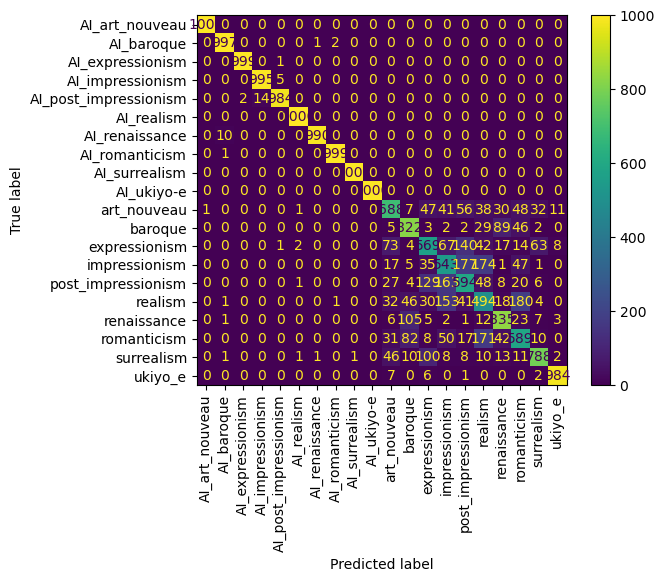

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=art_style_classes)

disp.plot()
plt.xticks(rotation=90)


In [54]:
torch.save(art_vision_model.state_dict(), "./art_vision_model_state.pt")

# GradCAM

In [55]:
def get_img_colour_features(image, col_feature_scaler):
    rgb_img_features = np.array(image.resize((1,1))).squeeze()
    hsv_img_features = np.array(image.convert('HSV').resize((1,1))).squeeze()
    cmyk_img_features = np.array(image.convert('CMYK').resize((1,1))).squeeze()[:-1]
    
    return torch.Tensor(col_feature_scaler.transform(
        [np.concatenate((rgb_img_features, hsv_img_features, cmyk_img_features))]
    ))

In [56]:
#art_vision_model = torch.load("/kaggle/input/art-model-pytorch/art_classifier.pt", map_location=device).module

In [57]:
def get_model_pred(model, art_img_tensor, art_img_col_features):
    for train_param in art_vision_model.features.parameters(): # TODO: For all layers of just for the features?
        train_param.requires_grad = True
    
    gradients = None
    activations = None

    def hook_backward(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output

    def hook_forward(module, args, output):
        nonlocal activations
        activations = output
        
# art_vision_model.features[-1][-1]       
#
#     CNBlock(
#       (block): Sequential(
#         (0): Conv2d(1024, 1024, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=1024) | Size [1, 1024, 7, 7]
#         (1): Permute()
#         (2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
#         (3): Linear(in_features=1024, out_features=4096, bias=True)
#         (4): GELU(approximate='none')
#         (5): Linear(in_features=4096, out_features=1024, bias=True)
#         (6): Permute()
#       )
#       (stochastic_depth): StochasticDepth(p=0.5, mode=row)
#     )
        
    hook_backward = model.features[-1][-1].block[0].register_full_backward_hook(hook_backward, prepend=False)
    hook_forward = model.features[-1][-1].block[0].register_forward_hook(hook_forward, prepend=False)
    
    model.eval()
    
    preds =  model(art_img_tensor.unsqueeze(0), art_img_col_features)
    pred_index = preds.argmax(dim=1)

    preds[:, pred_index].backward()
    
    hook_backward.remove()
    hook_forward.remove()
    
    for train_param in art_vision_model.features.parameters():
        train_param.requires_grad = False
    
    return pred_index, gradients, activations


In [58]:
def generate_grad_map(gradients, activations):

    avg_pooled_gradients = torch.mean(
        gradients[0], # Size [1, 1024, 7, 7]
        dim=[0, 2, 3]
    )

    # Weighting acitvation features (channels) using its related calculated Gradient
    for i in range(activations.size()[1]):
        activations[:, i, :, :] *= avg_pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()
    
    # L2 Normalisation # IMPROVED GRADCAM!!!!! EXPERIMENT MORE
    heatmap = F.normalize(heatmap)
        
    # relu on top of the heatmap
    heatmap = F.sigmoid(heatmap)

    # Min-max normalization of the heatmap
    heatmap = (heatmap - torch.min(heatmap))/(torch.max(heatmap) - torch.min(heatmap))

    return heatmap.detach()

In [59]:
test_art_img, _, test_art_labels = next(iter(valid_art_dl))

tensor(0)

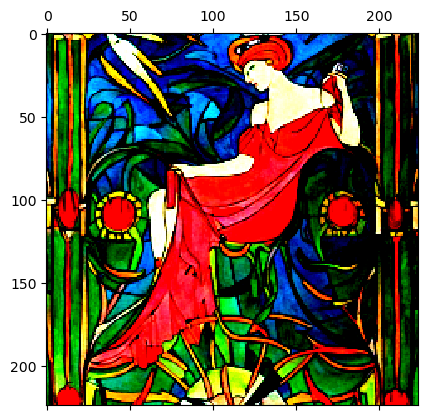

In [60]:
plt.matshow(test_art_img[6].permute(1,2,0))
test_art_labels[6]

In [61]:
img_col_features = get_img_colour_features(to_pil_image(test_art_img[6].detach()), col_feature_scaler)
pred_index, gradients, activations = get_model_pred(art_vision_model, test_art_img[6].to(device), img_col_features.to(device))
pred_index

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


tensor([0], device='cuda:0')

tensor([[0.0000, 0.3144, 0.4078, 0.1210, 0.8036, 1.0000, 0.8116],
        [0.1095, 0.3530, 0.2788, 0.0788, 0.8156, 0.9205, 0.6214],
        [0.1997, 0.4225, 0.4110, 0.0706, 0.5726, 0.5300, 0.3945],
        [0.4156, 0.5465, 0.4283, 0.1019, 0.3070, 0.3061, 0.4117],
        [0.4287, 0.5588, 0.4166, 0.0932, 0.3063, 0.3155, 0.4074],
        [0.3680, 0.4820, 0.4533, 0.2257, 0.3559, 0.2297, 0.3352],
        [0.3820, 0.4929, 0.4571, 0.3416, 0.2735, 0.1886, 0.3218]],
       device='cuda:0')


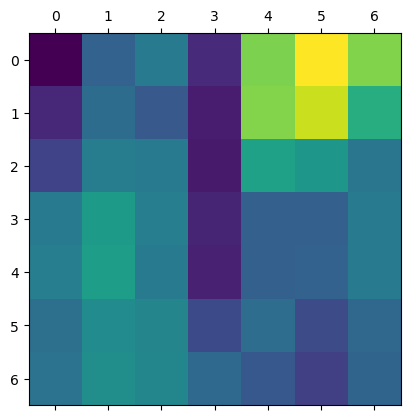

In [62]:
heatmap = generate_grad_map(gradients, activations)
print(heatmap)
plt.matshow(heatmap.cpu())

In [63]:
def predict_image(art_img, model, col_feature_scaler, hm_opacity=0.3):
    art_img = art_img.resize((img_h,img_h), resample=PIL.Image.BICUBIC)
    img_col_features = get_img_colour_features(art_img, col_feature_scaler)
    art_img_tensor = preprocess_transforms(art_img)
        
    pred_index, gradients, activations = get_model_pred(model, art_img_tensor.to(device), img_col_features.to(device))
    heatmap = generate_grad_map(gradients, activations)
        
    hm_overlay = to_pil_image(heatmap.detach().cpu(), mode='F').resize((img_h,img_h), resample=PIL.Image.BICUBIC)

    # Jet Colormap
    col_map = colormaps['YlOrRd']
    hm_overlay = PIL.Image.fromarray(
        (255 * col_map(np.asarray(hm_overlay) ** 2)[:, :, :3]).astype(np.uint8)
    )
    
    super_impossed_img = PIL.Image.blend(art_img, hm_overlay, alpha=hm_opacity)
    
    return pred_index, super_impossed_img

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ukiyo_e


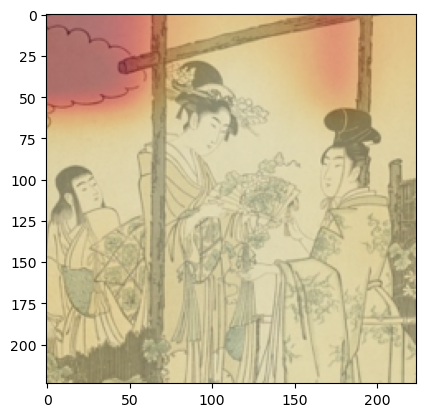

In [64]:
#art_image = PIL.Image.open("/kaggle/input/artbench-10-256px/artbench-10-imagefolder-split/artbench-10-imagefolder-split/test/art_nouveau/achille-beltrame_fly-of-gabriele-dannunzio-over-trieste-1915.jpg")
#art_image = PIL.Image.open("/kaggle/input/artbench-10-256px/artbench-10-imagefolder-split/artbench-10-imagefolder-split/test/romanticism/albert-bierstadt_sentinel-falls-and-cathedral-peaks-in-the-yosemite-valley-1864.jpg")
#art_image = PIL.Image.open("/kaggle/input/artbench-10-256px/artbench-10-imagefolder-split/artbench-10-imagefolder-split/test/realism/abbott-handerson-thayer_azores.jpg")
art_image = PIL.Image.open("/kaggle/input/artbench-10-256px/artbench-10-imagefolder-split/artbench-10-imagefolder-split/test/ukiyo_e/chokosai-eisho_99.jpg")
pred_index, pred_hm = predict_image(art_image, art_vision_model, col_feature_scaler, hm_opacity=0.4)
print(art_style_classes[pred_index])
plt.imshow(pred_hm)

In [65]:
# TODO: Modularise the code. Check Notion
# - Breakdown to classes
# - Saving best model function implementation
# - example: https://debuggercafe.com/saving-and-loading-the-best-model-in-pytorch/